# 本文件说明
- 训练模型,查看模型结果：包括K-fold、概率结果

# 基本设置

In [1]:
import jieba
from jieba import analyse
import sys
import re
import time
import string
from sklearn import feature_extraction
from sklearn.pipeline import Pipeline,FeatureUnion
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2,mutual_info_classif,f_classif 
from sklearn.preprocessing import StandardScaler

import xgboost as xgb
from xgboost import XGBClassifier
from sklearn import metrics

from sklearn.base import BaseEstimator, TransformerMixin

%matplotlib inline
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from collections import Counter

import warnings
warnings.filterwarnings('ignore')

In [2]:
from toolkits.nlp.generate_keywords import generate_keywords
import myclass_circ
from toolkits.nlp import load_save_plot_file

In [3]:
%load_ext autoreload
%autoreload 2

## 一些函数

In [4]:
def cal_kfold(title_content, label, pipeline, raw_folder, filename, class_name_dict):
    from sklearn.model_selection import KFold
    import numpy as np

    data_raw = pd.read_excel('%s/corpus/title_content_label.xlsx'%raw_folder)
    raw_title = np.array(data_raw['title'])
    raw_content = np.array(data_raw['content'])
    print('data_raw: ', data_raw.shape)

    kf = KFold(n_splits=5, shuffle=True, random_state=0)
    title_content = np.array(title_content)
    label = np.array(label)
    
    kfold_res = {'raw_title':[], 'raw_content':[], 'label':[], 
             'predict_label':[], 'title_content':[], 'predict_proba':[]}

    num = 0
    for train_index , test_index in kf.split(title_content):
        print('---- %s'%(num+1))
        X_train,X_test = title_content[train_index], title_content[test_index]
        y_train,y_test = label[train_index], label[test_index]
        
        pipeline.fit(X_train, y_train)
        print(pipeline.score(X_train, y_train))    

        y_pred_class = pipeline.predict(X_test)
        print('accuracy_score: ', metrics.accuracy_score(y_test, y_pred_class)) # 指所有分类正确的百分比
        print(metrics.classification_report(y_test, y_pred_class))
        print('confusion_matrix: ')
        print( metrics.confusion_matrix(y_test, y_pred_class))   
        
        y_pred_prob = pipeline.predict_proba(X_test)

        kfold_res['raw_title'] += list(raw_title[test_index])
        kfold_res['raw_content'] += list(raw_content[test_index])
        kfold_res['title_content'] += list(X_test)
        kfold_res['label'] += [class_name_dict[i] for i in y_test]
        kfold_res['predict_label'] += [class_name_dict[i] for i in y_pred_class]
        kfold_res['predict_proba'] += list(y_pred_prob.max(axis = 1))
    
        num += 1
        
    kfold_result = pd.DataFrame.from_dict(kfold_res, orient = 'index').T
    kfold_result['R_W'] = kfold_result.apply(lambda x: 'Right' if x['label'] == x['predict_label'] else 'Wrong', axis = 1)
    print('kfold_result: ', kfold_result.shape)
    
    with pd.ExcelWriter('%s/corpus/%s'%(raw_folder, filename)) as writer:
        for label in kfold_result['label'].unique():
            tmp_data = kfold_result[kfold_result['label'] == label]
            tmp_data.to_excel(writer, label, index = False)
        writer.save()

In [5]:
def plot_class_proba(y_pred_class, y_pred_prob):
    import seaborn as sns
    import matplotlib.pyplot as plt

    sel_data = pd.DataFrame()
    sel_data['predict_label'] = y_pred_class
    sel_data['predict_proba'] = y_pred_prob
    sel_data['label'] = y_test

    label_dic={'监管':1,'行业':2,'产品销售':3,'资本市场':4,'公司内部管理':5,'消费服务':6,'其他相关报道':7,'噪音':8}
    # sel_data['predict_label'] = sel_data['predict_label'].apply(lambda x:label_dic[x])
    g = sns.FacetGrid(sel_data, col="predict_label", col_wrap=4, sharex=False)
    g.map(plt.hist, "predict_proba", bins = 10)

    sel_data['proba'] = sel_data['predict_proba'].apply(lambda x:round(x, 1))
    sel_data_stat = sel_data.groupby(['predict_label', 'proba'])['predict_proba'].count().unstack().fillna(0)
    sel_data_stat['sum'] = sel_data_stat.sum(axis = 1)
    sel_data_stat.loc['sum'] = sel_data_stat.sum(axis = 0)
    return sel_data_stat

# 西藏教育厅：1 八分类

## 导入与分割数据

In [6]:
cbrc_filepath_class = 'cor_result/corpus/'
title_content, label, title, content = load_save_plot_file.title_content_label(cbrc_filepath_class)
label = [int(l) for l in label]
label[:5]

title num:  933
['萨基会 回到 拉萨 足球 时间 圆梦 世界屋脊', '梁思成 刘长春 东大 日子']
content num:  933
title_content num:  933
label num:  933
['1', '1', '1', '0', '0']


[1, 1, 1, 0, 0]

In [7]:
label_dic={'不相关':0,'相关':1}
class_name_dict = {v: k for k, v in label_dic.items()}
class_name_dict

{0: '不相关', 1: '相关'}

In [8]:
X_train, X_test, y_train, y_test = train_test_split(title_content, label, test_size=0.3, random_state=42)
print('训练集：',len(y_train))
print('训练集-各类数量：',Counter(y_train))
print('测试集：',len(y_test))
print('测试集-各类数量：',Counter(y_test))

训练集： 653
训练集-各类数量： Counter({0: 419, 1: 234})
测试集： 280
测试集-各类数量： Counter({0: 186, 1: 94})


## 生成词典

In [26]:
# g_k = generate_keywords(500)
# g_k.gen_keywords_by_class(title_content, label, v_thre = 3)

In [27]:
# g_k.save_txt('keywords_i.txt')

## features

In [38]:
# org = 'moe'
# model = 'class'
# date = '20181119'

In [39]:
# pipeline = Pipeline([
#     ('features', FeatureUnion([
#         ('tf_idf', Pipeline([
#             ('counts', CountVectorizer(max_df=0.95, min_df=2)),
#             ('tf_idf', TfidfTransformer()),
#             ('chi', SelectKBest(chi2, k=2000))
#         ])),
#         ('len_stats', myclass_circ.StatsFeatures_cor()),
#        # ('tf', myclass_circ.Statskeywords_cor(topk = 5000))
#     ])),
#     ('standard', StandardScaler(with_mean=False))
# ])

# pipeline_train = pipeline.fit(title_content, label)
# X_features = pipeline_train.transform(title_content)
# print(X_features.shape)

# from sklearn.externals import joblib
# joblib.dump(pipeline_train, "model/%s_%s_pipeline_%s.pkl.z"%(org, model, date))
# joblib.dump(X_features, "model/%s_%s_features_%s.pkl.z"%(org, model, date))
# joblib.dump(label, "model/%s_%s_labels_%s.pkl.z"%(org, model, date))

(1049, 2009)


['model/moe_class_labels_20181119.pkl.z']

In [ ]:
# from sklearn.externals import joblib
# pipeline_train = joblib.load( "model/circ_class_pipeline_20181108.pkl.z")
# X_features = joblib.load( "model/circ_class_features_20181108.pkl.z")
# label = joblib.load( "model/circ_class_labels_20181108.pkl.z")
# print(X_features.shape)
# print(len(label))

### tf

In [10]:
from collections import Counter
word_count = Counter(" ".join(title_content).split())
# word_count_sel = word_count.most_common(2000)
# word_count_sel
# word_count

word_count = pd.DataFrame.from_dict(word_count, orient='index' ).reset_index()
word_count.columns = ['word', 'count']
word_count = word_count.sort_values(by = 'count', ascending = False)
print(word_count.shape)
word_count_sel = word_count.iloc[:2000, :]
print(word_count_sel.shape)
word_count_sel.to_excel(r'cor_result\result\word_count_20181120.xlsx', index = False)
word_count.head()

(14658, 2)
(2000, 2)


word  count
16    西藏    615
213   中国    558
78    工作    403
258   大学    388
56    教育    387

## train & test

In [28]:
# a = myclass_circ.Statskeywords_cor(5000)
# len(a.keywords)

In [11]:
pipeline = Pipeline([
    ('features', FeatureUnion([
        ('tf_idf', Pipeline([
            ('counts', CountVectorizer(max_df=0.95, min_df=2)),
            ('tf_idf', TfidfTransformer()),
            ('chi', SelectKBest(chi2, k=2000))
        ])),
        ('len_stats', myclass_circ.StatsFeatures_cor()),
       # ('tf', myclass_circ.Statskeywords_cor(topk = 5000))
    ])),
    ('standard', StandardScaler(with_mean=False)),
    ('classifier', XGBClassifier(max_depth=7,objective='multi:softmax', num_class=2))
])

pipeline.fit(X_train, y_train)
print(pipeline.score(X_train, y_train))
pipeline

0.996937212863706


Pipeline(memory=None,
     steps=[('features', FeatureUnion(n_jobs=1,
       transformer_list=[('tf_idf', Pipeline(memory=None,
     steps=[('counts', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.9...tate=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1))])

In [12]:
y_pred_class = pipeline.predict(X_test)
print('accuracy_score: ', metrics.accuracy_score(y_test, y_pred_class)) # 指所有分类正确的百分比
print(metrics.classification_report(y_test, y_pred_class))
print('confusion_matrix: ')
print( metrics.confusion_matrix(y_test, y_pred_class))

accuracy_score:  0.9071428571428571
             precision    recall  f1-score   support

          0       0.93      0.93      0.93       186
          1       0.86      0.86      0.86        94

avg / total       0.91      0.91      0.91       280

confusion_matrix: 
[[173  13]
 [ 13  81]]


## 概率结果

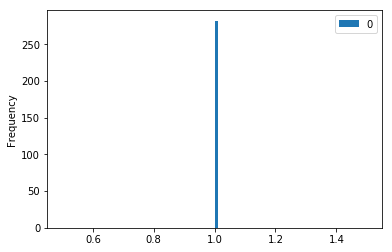

In [23]:
y_pred_prob = pipeline.predict_proba(X_test)
pd.DataFrame(y_pred_prob.max(axis = 1)).plot.hist(bins = 100)

proba          1.0  sum
predict_label          
0              203  203
1               79   79
sum            282  282

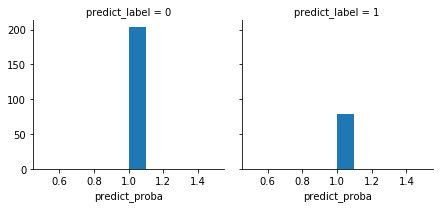

In [24]:
sel_data_stat = plot_class_proba(y_pred_class, y_pred_prob.max(axis = 1))
sel_data_stat

## K-fold

In [13]:
pipeline = Pipeline([
    ('features', FeatureUnion([
        ('tf_idf', Pipeline([
            ('counts', CountVectorizer(max_df=0.95, min_df=2)),
            ('tf_idf', TfidfTransformer()),
            ('chi', SelectKBest(chi2, k=2000))
        ])),
        ('len_stats', myclass_circ.StatsFeatures_cor()),
       # ('tf', myclass_circ.Statskeywords_cor(topk = 5000))
    ])),
    ('standard', StandardScaler(with_mean=False)),
    ('classifier', XGBClassifier(max_depth=7,objective='multi:softmax', num_class=2))
])

filename = 'moe_class_label_proba_20181120.xlsx'
cal_kfold(title_content, label, pipeline, 'cor_result', filename, class_name_dict)

data_raw:  (933, 5)
---- 1
0.9946380697050938
accuracy_score:  0.8716577540106952
             precision    recall  f1-score   support

          0       0.87      0.93      0.90       117
          1       0.87      0.77      0.82        70

avg / total       0.87      0.87      0.87       187

confusion_matrix: 
[[109   8]
 [ 16  54]]
---- 2
0.9946380697050938
accuracy_score:  0.9037433155080213
             precision    recall  f1-score   support

          0       0.91      0.94      0.93       123
          1       0.88      0.83      0.85        64

avg / total       0.90      0.90      0.90       187

confusion_matrix: 
[[116   7]
 [ 11  53]]
---- 3
0.9959785522788204
accuracy_score:  0.8877005347593583
             precision    recall  f1-score   support

          0       0.88      0.97      0.92       125
          1       0.92      0.73      0.81        62

avg / total       0.89      0.89      0.88       187

confusion_matrix: 
[[121   4]
 [ 17  45]]
---- 4
0.99732262382864

In [ ]:
# import xlrd

# kfold_result = pd.DataFrame()

# currentPath  = 'circ_result_class/corpus/circ_class_label_proba_20181008.xlsx'
# excel = xlrd.open_workbook(currentPath)
# sheet_names = [sheet.name for sheet in excel.sheets()]
# for sheet_name in sheet_names:   
#     tmp_data = pd.read_excel(currentPath, sheet_name)     
#     kfold_result = pd.concat([kfold_result, tmp_data], axis = 0)

# kfold_result.index = range(kfold_result.shape[0])
# kfold_result.insert(0, '备注', '')
# print('总数：', kfold_result.shape)
# # kfold_result.head()

In [ ]:
# K_S_sel = kfold_result[(kfold_result['predict_proba'] < 0.65) | (kfold_result['R_W'] == 'Wrong')]
# K_S_else = kfold_result[~((kfold_result['predict_proba'] < 0.65) | (kfold_result['R_W'] == 'Wrong'))]
# print(kfold_result.shape)
# print(K_S_else.shape)
# print(K_S_sel.shape)
# K_S_sel.groupby(['R_W', 'predict_label'])['label'].count()

In [ ]:
# fea_filename = 'cbrc_result_class/result/20181008_circ_class_sel.xlsx'
# with pd.ExcelWriter(fea_filename) as writer:
#     for label in K_S_sel['predict_label'].unique():
#         tmp_data = K_S_sel[K_S_sel['predict_label'] == label]
#         N = tmp_data.shape[0]
#         tmp_data.sample(n = N, axis = 0, random_state=42).to_excel(writer,label, index = False)    
#     writer.save()
    
# fea_filename = 'cbrc_result_class/result/20181008_circ_class_else.xlsx'
# with pd.ExcelWriter(fea_filename) as writer:
#     for label in K_S_else['predict_label'].unique():
#         tmp_data = K_S_else[K_S_else['predict_label'] == label]
#         N = tmp_data.shape[0]
#         tmp_data.sample(n = N, axis = 0, random_state=42).to_excel(writer,label, index = False)    
#     writer.save()    

In [ ]:
# y_test = kfold_result['predict_label'].tolist()
# y_pred_class = kfold_result['label'].tolist()
# print('accuracy_score: ', metrics.accuracy_score(y_test, y_pred_class)) # 指所有分类正确的百分比
# print(metrics.classification_report(y_test, y_pred_class))
# print('confusion_matrix: ')
# print( metrics.confusion_matrix(y_test, y_pred_class))

In [ ]:
# y_pred_prob = kfold_result['predict_proba'].tolist()

# sel_data_stat = plot_class_proba(y_pred_class, y_pred_prob)
# sel_data_stat

## 保存模型

In [14]:
pipeline = Pipeline([
    ('features', FeatureUnion([
        ('tf_idf', Pipeline([
            ('counts', CountVectorizer(max_df=0.95, min_df=2)),
            ('tf_idf', TfidfTransformer()),
            ('chi', SelectKBest(chi2, k=2000))
        ])),
        ('len_stats', myclass_circ.StatsFeatures_cor()),
        # ('tf', myclass_circ.Statskeywords_cor(topk = 5000))
    ])),
    ('standard', StandardScaler(with_mean=False)),
    ('classifier', XGBClassifier(max_depth=7,objective='multi:softmax', num_class=2))
])

pipeline.fit(title_content, label)
print(pipeline.score(title_content, label))
pipeline

0.9935691318327974


Pipeline(memory=None,
     steps=[('features', FeatureUnion(n_jobs=1,
       transformer_list=[('tf_idf', Pipeline(memory=None,
     steps=[('counts', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.9...tate=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1))])

In [15]:
from sklearn.externals import joblib
joblib.dump(pipeline, "model/moe_cor_1120.pkl.z")

['model/moe_cor_1120.pkl.z']

# test online model

In [22]:
import pandas as pd
import requests,json
from sklearn import metrics
import pre_cor_circ

In [17]:
def get_server_res(data, url, col_name):
    '''
    服务器接口测试程序
    传入 dict, 传出 DataFrame
    '''
    # data = {'record':[{'id':0,'title':'ss','content':'zzz'},]}
    # data = {"record":marked_human_data.iloc[:5,:3].to_dict(orient = 'records')}
    # url "http://47.93.77.19:10000/correlation_negative"
    headers={'content-type':'application/json'}
    result = requests.post(url,
                      data = json.dumps(data),
                      headers=headers, allow_redirects=True)
    # print(result.text)
    json_data = json.loads(result.text)
    parse_data = []
    elapsed_time = json_data['elapsed_time']
    for i in range(len(json_data['docs'])):
        parse_data.append([json_data['docs'][i]['id'],
                          json_data['docs'][i][col_name]])
    parse_data = pd.DataFrame(parse_data, columns = ['id', col_name])    
    return parse_data, elapsed_time

In [34]:
fiel_path = r'cor_data\1119-1120西藏教育厅语料.xlsx'

# combined_data_1 = pd.read_excel(fiel_path, '0')
# combined_data_2 = pd.read_excel(fiel_path, '-1')
# combined_data = pd.concat([combined_data_1, combined_data_2])
combined_data_all = pd.read_excel(fiel_path)
combined_data_all['title_content'] = combined_data_all['title']+'。'+combined_data_all['content']
print(combined_data_all.shape)
combined_data = combined_data_all.loc[:2000, :]
combined_data['id'] = range(combined_data.shape[0])
print(combined_data.shape)

(52, 13)
(52, 14)


In [35]:
from sklearn.externals import joblib
pipeline = joblib.load("model/moe_cor_1120.pkl.z")

title_content = pre_cor_circ.handle_contents(combined_data['title_content'].tolist())
local_label = pipeline.predict(title_content)
combined_data['local_label'] = local_label

print(combined_data.shape)
combined_data.head()

(52, 15)


title     网站  \
0              姚雅静的散文 ▌香椿、蒲公英和油菜花 | 主播：周德清     微信   
1            致敬传承钟扬“种子精神”：复旦剧社话剧《种子天堂》在京首演  葫芦岛晚报   
2            勒流街道举办2018“夕阳金韵 和谐勒流”退休职工文艺晚会     微信   
3  红垦星地公司开展“学习时代楷模，弘扬爱国奋斗精神、建功立业新时代”主题党日活动     微信   
4         通讯：在歌声里学习汉语——中国驻黎巴嫩使馆举办黎学生唱汉语歌比赛   凤凰新闻   

                                                文章链接                 发布时间  \
0  http://mp.weixin.qq.com/s?__biz=MzI5NjMwMzI1OA...  2018-11-19 14:56:58   
1  http://epaper.hldnews.com/shtml/hldwb/20181119...  2018-11-19 14:54:22   
2  http://mp.weixin.qq.com/s?__biz=MzI1NTI5Mjc3Ng...  2018-11-19 13:31:40   
3  http://mp.weixin.qq.com/s?__biz=MzI3MDUwNDcxOQ...  2018-11-19 13:11:21   
4  http://share.iclient.ifeng.com/shareNews?aid=s...  2018-11-19 12:50:00   

    出处/作者 倾向性   媒介  阅读/点击  回复/评论  转载/转发  \
0    吟诗品文   中   微信      0      0      0   
1      佚名   中   平媒      0      0      0   
2  顺德民政人社   正   微信      0      0      0   
3    农投先锋   正   微信      0      0      0   
4      佚名   中  APP      0      0      0   

                                                文章摘要  \
0  特别是油菜花、蒲公英和香椿树,周德清 周德清的诗▌腊八节 |主播,周德清 周德清的诗丨雨水|...   
1  《种子天堂》根据复旦大学植物学家钟扬生前感人事迹编排创作,《种子天堂》用生动丰富、喜闻乐见的...   
2  当晚的退休职工文艺晚会由勒流街道人社局联合江义村委会举办,这也是勒流街道人社局连续五年举办退...   
3  弘扬爱国奋斗精神、建功立业新时代,爱国奋斗精神、建功立业新时代,宣传委员张欢同志带领大家观看...   
4  在歌声里学习汉语——中国驻黎巴嫩使馆举办黎学生唱汉语歌比赛,黎巴嫩学生唱汉语歌曲比赛上,学习...   

                                             content  \
0  赏花弄月，吟诗品文。戳上面蓝字免费关注！ 香椿、蒲公英和油菜花 （轻点以上音频同步收听，朗诵...   
1  新华社北京11月17日电（记者陈芳、陈聪）“任何生命都有其结束的一天，但我毫不畏惧，因为我的...   
2  简报 11月15日晚，“中国最美乡村”勒流街道江义村的影剧内灯光璀璨，载歌载舞，欢声朗朗，勒...   
3  主题党日 为全面深入学习贯彻习近平总书记关于人才工作、知识分子工作重要指示精神，引导广大干部...   
4  原标题：通讯：在歌声里学习汉语——中国驻黎巴嫩使馆举办黎学生唱汉语歌比赛  \n 图集   ...   

                                       title_content  id  local_label  
0  姚雅静的散文 ▌香椿、蒲公英和油菜花 | 主播：周德清。赏花弄月，吟诗品文。戳上面蓝字免费关...   0            1  
1  致敬传承钟扬“种子精神”：复旦剧社话剧《种子天堂》在京首演。新华社北京11月17日电（记者陈...   1            1  
2  勒流街道举办2018“夕阳金韵 和谐勒流”退休职工文艺晚会。简报 11月15日晚，“中国最美...   2            1  
3  红垦星地公司开展“学习时代楷模，弘扬爱国奋斗精神、建功立业新时代”主题党日活动。主题党日 为...   3            1  
4  通讯：在歌声里学习汉语——中国驻黎巴嫩使馆举办黎学生唱汉语歌比赛。原标题：通讯：在歌声里学习...   4            1

In [36]:
# combined_data['id'] = range(combined_data.shape[0])
combined_data['title'] = combined_data['title'].astype(str) 
combined_data['content'] = combined_data['content'].astype(str)
data = {"record":combined_data.loc[:,['id', 'title' ,'content']].to_dict(orient = 'records')}
url = "http://59.110.221.156:9000/judge_correlation"
col_name = 'cor'
parse_data, elapsed_time = get_server_res(data, url, col_name)
parse_data.columns = ['id', 'online_label']
print(parse_data.shape)
parse_data.head()

(52, 2)


id  online_label
0   0             1
1   1             1
2   2             1
3   3             1
4   4             1

In [37]:
parse_data['online_label'].value_counts()

1    42
0    10
Name: online_label, dtype: int64

In [38]:
tend_data = pd.merge(parse_data, combined_data, on = 'id', how = 'inner')
print(tend_data.shape)
tend_data.head()

(52, 16)


id  online_label                                    title     网站  \
0   0             1              姚雅静的散文 ▌香椿、蒲公英和油菜花 | 主播：周德清     微信   
1   1             1            致敬传承钟扬“种子精神”：复旦剧社话剧《种子天堂》在京首演  葫芦岛晚报   
2   2             1            勒流街道举办2018“夕阳金韵 和谐勒流”退休职工文艺晚会     微信   
3   3             1  红垦星地公司开展“学习时代楷模，弘扬爱国奋斗精神、建功立业新时代”主题党日活动     微信   
4   4             1         通讯：在歌声里学习汉语——中国驻黎巴嫩使馆举办黎学生唱汉语歌比赛   凤凰新闻   

                                                文章链接                 发布时间  \
0  http://mp.weixin.qq.com/s?__biz=MzI5NjMwMzI1OA...  2018-11-19 14:56:58   
1  http://epaper.hldnews.com/shtml/hldwb/20181119...  2018-11-19 14:54:22   
2  http://mp.weixin.qq.com/s?__biz=MzI1NTI5Mjc3Ng...  2018-11-19 13:31:40   
3  http://mp.weixin.qq.com/s?__biz=MzI3MDUwNDcxOQ...  2018-11-19 13:11:21   
4  http://share.iclient.ifeng.com/shareNews?aid=s...  2018-11-19 12:50:00   

    出处/作者 倾向性   媒介  阅读/点击  回复/评论  转载/转发  \
0    吟诗品文   中   微信      0      0      0   
1      佚名   中   平媒      0      0      0   
2  顺德民政人社   正   微信      0      0      0   
3    农投先锋   正   微信      0      0      0   
4      佚名   中  APP      0      0      0   

                                                文章摘要  \
0  特别是油菜花、蒲公英和香椿树,周德清 周德清的诗▌腊八节 |主播,周德清 周德清的诗丨雨水|...   
1  《种子天堂》根据复旦大学植物学家钟扬生前感人事迹编排创作,《种子天堂》用生动丰富、喜闻乐见的...   
2  当晚的退休职工文艺晚会由勒流街道人社局联合江义村委会举办,这也是勒流街道人社局连续五年举办退...   
3  弘扬爱国奋斗精神、建功立业新时代,爱国奋斗精神、建功立业新时代,宣传委员张欢同志带领大家观看...   
4  在歌声里学习汉语——中国驻黎巴嫩使馆举办黎学生唱汉语歌比赛,黎巴嫩学生唱汉语歌曲比赛上,学习...   

                                             content  \
0  赏花弄月，吟诗品文。戳上面蓝字免费关注！ 香椿、蒲公英和油菜花 （轻点以上音频同步收听，朗诵...   
1  新华社北京11月17日电（记者陈芳、陈聪）“任何生命都有其结束的一天，但我毫不畏惧，因为我的...   
2  简报 11月15日晚，“中国最美乡村”勒流街道江义村的影剧内灯光璀璨，载歌载舞，欢声朗朗，勒...   
3  主题党日 为全面深入学习贯彻习近平总书记关于人才工作、知识分子工作重要指示精神，引导广大干部...   
4  原标题：通讯：在歌声里学习汉语——中国驻黎巴嫩使馆举办黎学生唱汉语歌比赛  \n 图集   ...   

                                       title_content  local_label  
0  姚雅静的散文 ▌香椿、蒲公英和油菜花 | 主播：周德清。赏花弄月，吟诗品文。戳上面蓝字免费关...            1  
1  致敬传承钟扬“种子精神”：复旦剧社话剧《种子天堂》在京首演。新华社北京11月17日电（记者陈...            1  
2  勒流街道举办2018“夕阳金韵 和谐勒流”退休职工文艺晚会。简报 11月15日晚，“中国最美...            1  
3  红垦星地公司开展“学习时代楷模，弘扬爱国奋斗精神、建功立业新时代”主题党日活动。主题党日 为...            1  
4  通讯：在歌声里学习汉语——中国驻黎巴嫩使馆举办黎学生唱汉语歌比赛。原标题：通讯：在歌声里学习...            1

In [40]:
tend_data.to_excel(r'cor_data\1119-1120西藏教育厅语料1.xlsx', index = False)

In [39]:
# y_pred_class = pipeline.predict(X_test)
y_pred_class = tend_data['online_label'].tolist()
y_test = tend_data['local_label'].tolist()
print('accuracy_score: ', metrics.accuracy_score(y_test, y_pred_class)) # 指所有分类正确的百分比
print(metrics.classification_report(y_test, y_pred_class))
print('confusion_matrix: ')
print( metrics.confusion_matrix(y_test, y_pred_class))

accuracy_score:  1.0
             precision    recall  f1-score   support

          0       1.00      1.00      1.00        10
          1       1.00      1.00      1.00        42

avg / total       1.00      1.00      1.00        52

confusion_matrix: 
[[10  0]
 [ 0 42]]


In [30]:
for k in range(1,10):    
    combined_data = combined_data_all.loc[2000 * (k-1):2000 * k, :]
    combined_data['title'] = combined_data['title'].astype(str) 
    combined_data['content'] = combined_data['content'].astype(str)
    data = {"record":combined_data.loc[:,['id', 'title' ,'content']].to_dict(orient = 'records')}
    url = "http://59.110.221.156:9000/judge_correlation"
    col_name = 'cor'
    parse_data, elapsed_time = get_server_res(data, url, col_name)
    parse_data.columns = ['id', 'online_label']
#     print(parse_data.shape)
    parse_data.head()
    print("第 %s 次，数据量：%s，耗时：%s s"%(k, combined_data.shape[0], elapsed_time))

第 1 次，数据量：2001，耗时：17.00 s
第 2 次，数据量：2001，耗时：19.00 s
第 3 次，数据量：2001，耗时：23.00 s
第 4 次，数据量：2001，耗时：27.00 s
第 5 次，数据量：2001，耗时：27.00 s
第 6 次，数据量：2001，耗时：27.00 s
第 7 次，数据量：2001，耗时：26.00 s
第 8 次，数据量：1144，耗时：16.00 s


JSONDecodeError: Expecting value: line 1 column 1 (char 0)